
BUTTERFLY IMAGE CLASSIFICATION USING PYTORCH 


In [31]:
#  IMPORT LIBRARIES 
# os: for file path handling
# numpy: numerical operations (arrays, etc.)
# matplotlib: for plotting 
# pandas: reading and working with CSV files (train/test metadata)
# PIL.Image: to open and handle image files
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
# PyTorch core imports:
# Dataset, DataLoader: building input pipelines
# transforms: image preprocessing (resize, normalize, etc.)
# models: pretrained architectures like ResNet
# nn: neural network layers and loss functions
# optim: optimization algorithms such as Adam

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim

In [32]:
# DEFINE BASE PATHS 
# BASE_DIR: the root folder of the butterfly dataset on disk.
# TRAIN_DIR / TEST_DIR: subfolders for train and test images.
# Note: "Train " and "Test " actually contain trailing spaces in their names,
# so we must use them exactly as they appear in the filesystem.

BASE_DIR = "/Users/hatemelgenedy/Desktop/AI and Data Science Microsoft course/Butterfly dataset"

# TRAIN_IMAGES_DIR: the folder that stores the actual training images.
# TEST_IMAGES_DIR: the folder that stores the actual test images.
# Note the leading space in " butterfly_train" because the folder name has it.
TRAIN_DIR = os.path.join(BASE_DIR, "Train ")
TEST_DIR  = os.path.join(BASE_DIR, "Test ")

#Sanity check: print whether these image directories actually exist on disk.
TRAIN_IMAGES_DIR = os.path.join(TRAIN_DIR, " butterfly_train")   # note leading space
TEST_IMAGES_DIR  = os.path.join(TEST_DIR, "butterfly_test")

print("Train images dir exists? ", os.path.exists(TRAIN_IMAGES_DIR))
print("Test images dir exists?  ", os.path.exists(TEST_IMAGES_DIR))

Train images dir exists?  True
Test images dir exists?   True


In [33]:
# LOAD CSV FILES 
# The dataset uses CSV files to map image filenames to labels.
# Training_set.csv: has 'filename' + 'label' columns.
# Testing_set.csv: has only 'filename' (no labels).
TRAIN_CSV_PATH = os.path.join(BASE_DIR, "Training_set.csv")
TEST_CSV_PATH  = os.path.join(BASE_DIR, "Testing_set.csv")

In [34]:
# Read CSVs into pandas DataFrames for easy manipulation.

train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df  = pd.read_csv(TEST_CSV_PATH)

In [35]:
# Quick look at the first few rows and shape of each dataframe.

print(train_df.head())
print(test_df.head())
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

      filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART
      filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg
Train shape: (6499, 2)
Test shape: (2786, 1)


In [37]:
# ENCODE LABELS (STRING → INTEGER) 
# Neural networks work with numbers, not strings.
# We convert butterfly species names (e.g., "MONARCH") to integer indices.

# list of unique class names from the 'label' column.

class_names = sorted(train_df["label"].unique())

# Counting how many different butterfly species we have.

num_classes = len(class_names)
print("Num classes:", num_classes)

# Create mapping from label string to integer index.
label_to_index = {name: i for i, name in enumerate(class_names)}

# Create reverse mapping from integer index to label string.
index_to_label = {i: name for name, i in label_to_index.items()}  # helper for decoding

# Add a new column 'label_idx' to train_df that stores the numeric label.
# .map() applies our dictionary to the 'label' column.
train_df["label_idx"] = train_df["label"].map(label_to_index)

#  checking to confirm we now have 'label_idx'.
train_df.head()

Num classes: 75


,filename,label,label_idx
0,Image_1.jpg,SOUTHERN DOGFACE,66
1,Image_2.jpg,ADONIS,0
2,Image_3.jpg,BROWN SIPROETA,12
3,Image_4.jpg,MONARCH,44
4,Image_5.jpg,GREEN CELLED CATTLEHEART,33


In [38]:
# DEFINE IMAGE TRANSFORMS 
# IMG_SIZE: target size (height and width) for all images.
# BATCH_SIZE: how many images to process in one training step.

IMG_SIZE = 224
BATCH_SIZE = 32

# train_transform:
# - Resize: ensure all images are 224x224, as expected by ResNet.
# - RandomHorizontalFlip: simple data augmentation to help generalization.
# - ToTensor: convert from PIL image (H x W x C) to PyTorch tensor (C x H x W).
# - Normalize: standard ImageNet normalization since we're using a pretrained model.

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# test_transform:
# Similar to train, but without random augmentation (we want deterministic behavior on test data).
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [39]:
# CUSTOM DATASET CLASSES 
# We define our own Dataset classes because our labels come from CSV files,
# not from folder names as in torchvision.datasets.ImageFolder.

class ButterflyTrainDataset(Dataset):
    # __init__ is called once when creating the dataset object.
    # images_dir: folder where the actual image files live
    # transform: transforms (resize, normalize, etc.)
    def __init__(self, df, images_dir, transform=None):
        # We reset the index so that __getitem__ can use a clean 0..N-1 index.
        # drop=True: we don't keep the old index column, we just reindex.
        self.df = df.reset_index(drop=True)
        self.images_dir = images_dir
        self.transform = transform

 # __len__ tells PyTorch how many samples are in the dataset.
    def __len__(self):
        return len(self.df)

# __getitem__ loads and returns a single sample at the given index.
    def __getitem__(self, idx):
        # Get the row corresponding to this index.
        row = self.df.iloc[idx]
        filename = row["filename"]
        label_idx = int(row["label_idx"])

# Build the full path to the image file.
        img_path = os.path.join(self.images_dir, filename)
        # Open the image with PIL and convert to RGB to ensure 3 channels.
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

# Convert the numeric label to a tensor of type long (required by CrossEntropyLoss).
        label_tensor = torch.tensor(label_idx, dtype=torch.long)
        # Return a tuple (image_tensor, label_tensor) for this sample.
        return image, label_tensor


# Similar to ButterflyTrainDataset, but without labels.
    # This is used for the test set where we only have filenames.
class ButterflyTestDataset(Dataset):
    def __init__(self, df, images_dir, transform=None):
         # Reset index to simplify indexing.
        self.df = df.reset_index(drop=True)
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["filename"]

        img_path = os.path.join(self.images_dir, filename)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

# We return (image, filename) so we can later match predictions back to the original file.
        return image, filename

In [40]:
# CREATE DATASET OBJECTS 
# Here we instantiate our custom Dataset classes with the appropriate
# DataFrames, directories, and transforms.

train_dataset = ButterflyTrainDataset(
    df=train_df,
    images_dir=TRAIN_IMAGES_DIR,
    transform=train_transform
)

test_dataset = ButterflyTestDataset(
    df=test_df,
    images_dir=TEST_IMAGES_DIR,
    transform=test_transform
)

In [41]:
# CREATE DATALOADERS 
# DataLoaders handle batching, shuffling, and parallel loading of data.
# num_workers=0: important for Jupyter/macOS to avoid multiprocessing pickling errors.

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,   # shuffle=True: helps break any ordering in the data and improves training.
    num_workers=0,  # 0 means data loading happens in the main process (safer in notebooks).
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # no need to shuffle test data; we want predictions in the same order.
    num_workers=0,
)


In [42]:
#  SELECT DEVICE (GPU / MPS / CPU) 
# We use the best available device:
# - CUDA GPU if available
# - Apple Silicon MPS if available
# - Otherwise, fall back to CPU.

device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)
print("Using device:", device)


Using device: mps


In [43]:
#  LOAD PRETRAINED RESNET18 MODEL 
# We use transfer learning with a pretrained ResNet18 model on ImageNet.
# weights=... loads pretrained weights that already know generic image features.

resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)


In [44]:
# The original final fully connected (fc) layer outputs 1000 classes (ImageNet).
# We replace it with a new Linear layer that outputs num_classes (butterfly species).
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

# Move the model to the selected device (GPU / MPS / CPU).
resnet = resnet.to(device)


# DEFINE LOSS FUNCTION AND OPTIMIZER 
# CrossEntropyLoss is standard for multi-class classification tasks.
# Adam is a commonly used optimizer that adapts the learning rate for each parameter.

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-4)

In [ ]:
#  TRAINING LOOP 
# tqdm is used just for a progress bar in the notebook.
from tqdm.auto import tqdm  

# EPOCHS: how many times we go through the entire training dataset.
EPOCHS = 5  

for epoch in range(EPOCHS):
    # Set the model to training mode (enables dropout, batchnorm updates, etc.).
    #ResNet stands for Residual Network, a deep convolutional neural network used for image classification.
    # Put the model into TRAINING mode.
# This enables dropout layers and updates BatchNorm statistics,
# which are necessary for proper learning during training.
    resnet.train() 

    # Initialize the running loss for this epoch.
# We accumulate the loss from every batch into this variable
# so we can compute the average loss at the end of the epoch.
    running_loss = 0.0  

    # Counter for how many predictions the model got correct.
# Updated each batch by comparing predicted labels to true labels. 
    correct = 0
    # Counter for total number of samples processed in this epoch.
# Used along with 'correct' to compute accuracy.
    total = 0

    # tqdm creates a nice progress bar over the batches in the DataLoader.
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    for images, labels in loop:
        # Move data to the same device as the model.
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients from the previous step.
        optimizer.zero_grad()

        # Forward pass: compute model outputs.
        outputs = resnet(images)

        # Compute loss between outputs and true labels.
        loss = criterion(outputs, labels)

        # Backward pass: compute gradients of the loss w.r.t. model parameters.
        loss.backward()

        # Update model parameters using the optimizer.
        optimizer.step()

        # Accumulate loss * number of samples to compute average loss later.
        running_loss += loss.item() * images.size(0)

        # Get predicted class indices (the index of the max logit per sample).
        _, preds = torch.max(outputs, 1)

        # Count how many predictions are correct in this batch.
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update the tqdm progress bar with the current loss value.
        loop.set_postfix(loss=loss.item())

    # Compute average loss and accuracy over the entire epoch.
    epoch_loss = running_loss / total
    epoch_acc = correct / total

    # Print metrics so we can see training progress.
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}")

Epoch 1/5:   0%|          | 0/204 [00:00<?, ?it/s]

In [ ]:
#  MODEL EVALUATION / PREDICTION ON TEST SET 
# After training, we switch the model to evaluation mode.
# This disables dropout and tells batchnorm to use running averages.
resnet.eval()

# We disable gradient calculations to:
# - speed up inference
# - reduce memory usage
# Since we are not training here, gradients are unnecessary.
all_filenames = []
all_pred_indices = []

with torch.no_grad():

    # tqdm progress bar over the test DataLoader
    for images, filenames in tqdm(test_loader, desc="Predicting on Test Set", leave=False):

        # Move images to the same device as the model
        images = images.to(device)

        # Forward pass (no backward since we're in no_grad mode)
        outputs = resnet(images)

        # Get predicted class index for each image
        # torch.max returns (max_value, index_of_max_value)
        _, preds = torch.max(outputs, 1)

        # Convert predictions from GPU/MPS tensors to CPU numpy arrays for storage
        preds = preds.cpu().numpy()

        # Save predictions and filenames for later use
        # extend() adds all items from preds instead of nesting the array
        all_filenames.extend(filenames)
        all_pred_indices.extend(preds)

Predicting on Test Set:   0%|          | 0/88 [00:00<?, ?it/s]

In [ ]:
# DECODE PREDICTIONS TO LABEL NAMES 
# Now we convert numeric class indices (e.g. 12)
# back into human-readable labels (e.g. "MONARCH").
all_pred_labels = [index_to_label[int(idx)] for idx in all_pred_indices]

# ATTACH PREDICTIONS TO test_df 
# test_df originally contains only filenames; we add:
#       pred_label_idx  → numeric prediction
#       pred_label      → decoded butterfly species name

test_df["pred_label_idx"] = all_pred_indices
test_df["pred_label"] = all_pred_labels

# Display the first few prediction rows to verify
print(test_df.head())

      filename  pred_label_idx              pred_label
0  Image_1.jpg              52              PINE WHITE
1  Image_2.jpg              24           CRIMSON PATCH
2  Image_3.jpg               0                  ADONIS
3  Image_4.jpg              36         IPHICLUS SISTER
4  Image_5.jpg              43  MILBERTS TORTOISESHELL


In [ ]:
# ---- PREDICTIONS VS ACTUAL AS A PLOT (CONFUSION MATRIX) ----

# We will evaluate the model on the TRAIN set here.
from sklearn.metrics import confusion_matrix

# Put model in evaluation model
resnet.eval()

all_true = []   # will store all true labels (integers)
all_pred = []   # will store all predicted labels (integers)

with torch.no_grad():  # no_grad() makes inference faster and uses less memory
    for images, labels in train_loader:
        # Move images and labels to the same device as the model
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass: get model outputs
        outputs = resnet(images)

        # Get the predicted class index for each sample in the batch
        _, preds = torch.max(outputs, 1)

        # Move tensors back to CPU and convert to numpy arrays
        all_true.extend(labels.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())


In [ ]:
import seaborn as sns

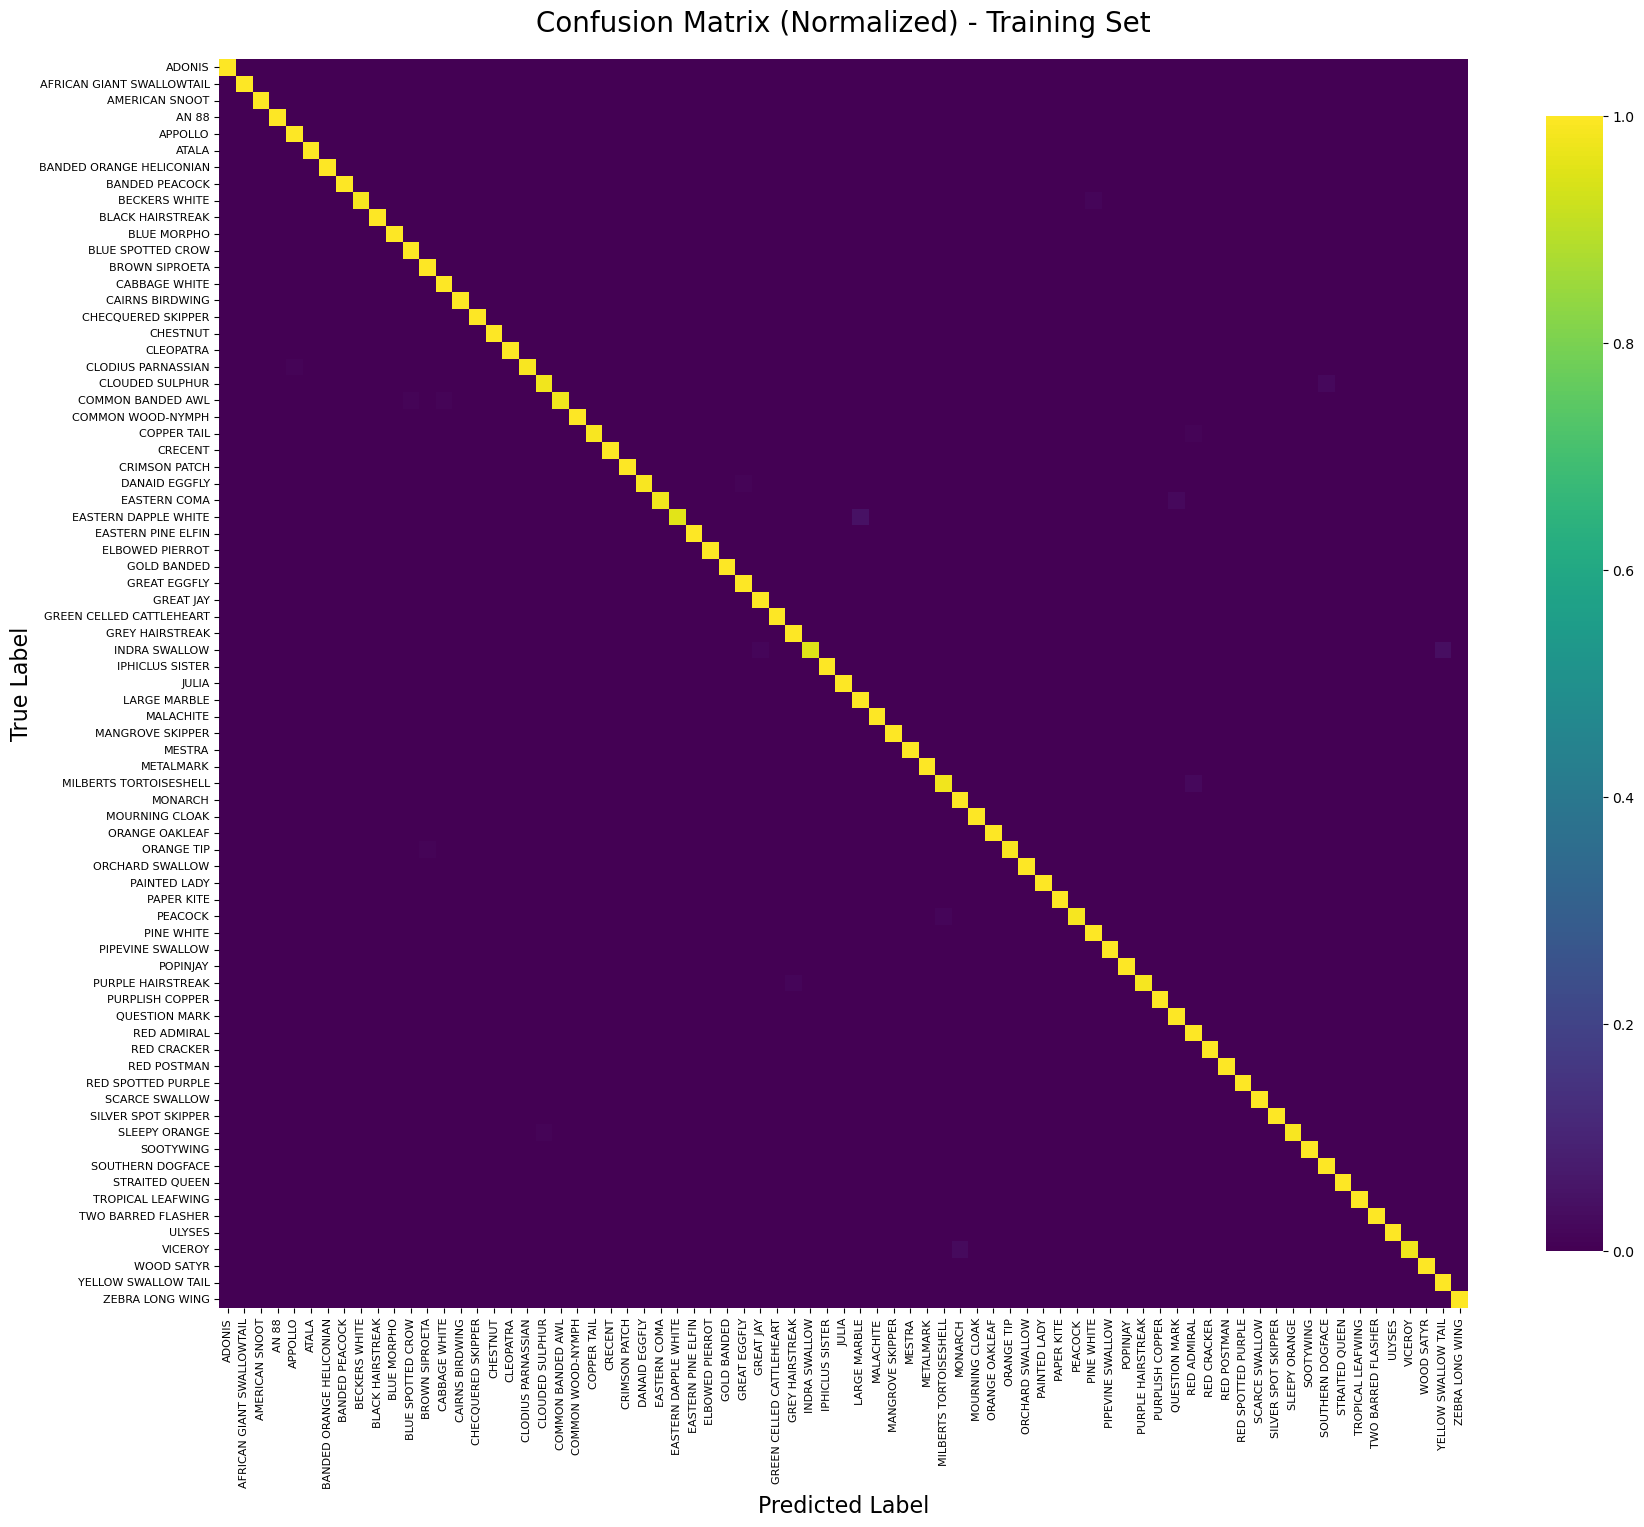

In [ ]:
# Building the confusion matrix
# ---------------------------------------------------------------
# cm[i][j] = number of class i samples predicted as class j
cm = confusion_matrix(all_true, all_pred)

# Normalized confusion matrix: each row sums to 1
# This makes the diagonal exactly the % accuracy per class
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

# ---------------------------------------------------------------
# Create a large, clean, readable heatmap
# ---------------------------------------------------------------
plt.figure(figsize=(18, 16))  # Large figure → readable labels

# seaborn.heatmap makes the confusion matrix visually clear
sns.heatmap(
    cm_norm,
    annot=False,                 # Set True if you want numbers inside each cell
    cmap="viridis",              # Clean & modern color map
    square=True,                 # Keep cells square-shaped
    cbar_kws={'shrink': 0.8},    # Shrink colorbar so it looks neat
    xticklabels=class_names,     # Use butterfly species names on axes
    yticklabels=class_names
)

# ---------------------------------------------------------------
# Titles and pretty formatting
# ---------------------------------------------------------------
plt.title("Confusion Matrix (Normalized) - Training Set", fontsize=20, pad=20)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)

# Rotate X labels vertical so they don't overlap
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

plt.tight_layout()  # Removes unnecessary margins
plt.show()

# This plot:
is a normalized confusion matrix for your entire training set.

# A confusion matrix compares:
True label (what the butterfly actually is)
Predicted label (what the model predicted)

# WHAT THE DIAGONAL MEANS (Yellow Line)
The bright yellow diagonal from top-left to bottom-right means:

The model predicted almost every training sample correctly

For each class, normalized accuracy is very close to 1.0 (100%)

# Because the matrix is normalized row-wise:
Each row = one butterfly species

Each cell = percentage of samples predicted as each class

Diagonal = correct predictions

Off-diagonal = incorrect predictions

# Since the diagonal is solid yellow and bright:
The model is extremely accurate on the training data
There are almost no mistaken predictions on training images

# WHAT THE DARK PURPLE MEANS
Everything that is dark purple represents:

0% or near-zero misclassification
The model does not confuse species
Other classes were almost never predicted incorrectly

# BRIGHT YELLOW CELLS == 100% accuracy for that species
Each yellow square on the diagonal means:

“For this butterfly species, the model got 100% of the training images correct.”

we have ~75 species, and the diagonal shows nearly all at 1.0.


# VERY FEW Off-Diagonal Dots
There are a few tiny scattered blue dots away from the diagonal.

Those mean:

The model made a very small number of mistakes


In [ ]:
# CREATE TRAIN/VALIDATION SPLIT (80% train, 20% validation)

from sklearn.model_selection import train_test_split

# Split the DataFrame into train and validation sets
train_df_split, val_df = train_test_split(
    train_df,
    test_size=0.2,          # 20% validation
    random_state=42,        # makes split reproducible
    stratify=train_df["label_idx"]   # keeps class distribution balanced
)

print("Train split:", train_df_split.shape)
print("Validation split:", val_df.shape)

Train split: (5199, 3)
Validation split: (1300, 3)


In [ ]:
for epoch in range(EPOCHS):  
    # Run one full pass over the training data (one epoch).
    # We'll track loss and accuracy for this epoch.

    # -------- TRAINING --------
    running_loss = 0.0; correct = 0; total = 0
    # Initialize counters to accumulate loss and accuracy over all batches.

    for x, y in train_loader:
        # For each batch: forward pass, compute loss, backward pass, update weights.

        # Update running totals so we can compute average metrics later.
        # correct counts predictions; total counts samples.
        pass

    train_epoch_loss = running_loss / total
    # Compute the average training loss for this epoch.
    train_epoch_acc = correct / total
    # Compute training accuracy across all samples this epoch.

    # -------- VALIDATION --------
    val_running_loss = 0.0; val_correct = 0; val_total = 0
    # Same idea as training, but we don’t update the model.

    with torch.no_grad():
        # Disable gradients because validation does not train the model.

        for x, y in val_loader:
            # Forward pass only to measure model performance on unseen data.

            # Update validation totals for loss and accuracy.
            pass

    val_epoch_loss = val_running_loss / val_total
    # Average validation loss for this epoch.
    val_epoch_acc = val_correct / val_total
    # Validation accuracy across the entire validation set.

    # -------- STORE METRICS --------
    train_losses.append(train_epoch_loss)
    train_accs.append(train_epoch_acc)
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    # Save this epoch’s metrics so we can plot training curves later.

    print(f"Epoch {epoch+1}/{EPOCHS}")
    # Show progress so we can monitor training.
    print(f"  Train Loss: {train_epoch_loss:.4f} | Train Acc: {train_epoch_acc:.4f}")
    print(f"  Val Loss:   {val_epoch_loss:.4f} | Val Acc:   {val_epoch_acc:.4f}")
    # Display both training and validation performance for this epoch.

In [ ]:
# Create the training dataset using the 80% split.
# I use train_transform because training images should have augmentation.
train_dataset = ButterflyTrainDataset(
    df=train_df_split,
    images_dir=TRAIN_IMAGES_DIR,
    transform=train_transform
)

# Create the validation dataset using the 20% split.
# I use test_transform (NO augmentation) for clean evaluation.
val_dataset = ButterflyTrainDataset(
    df=val_df,
    images_dir=TRAIN_IMAGES_DIR,
    transform=test_transform
)

In [ ]:
# Training DataLoader: shuffle=True to randomize batches each epoch.
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# Validation DataLoader: shuffle=False to keep order consistent.
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

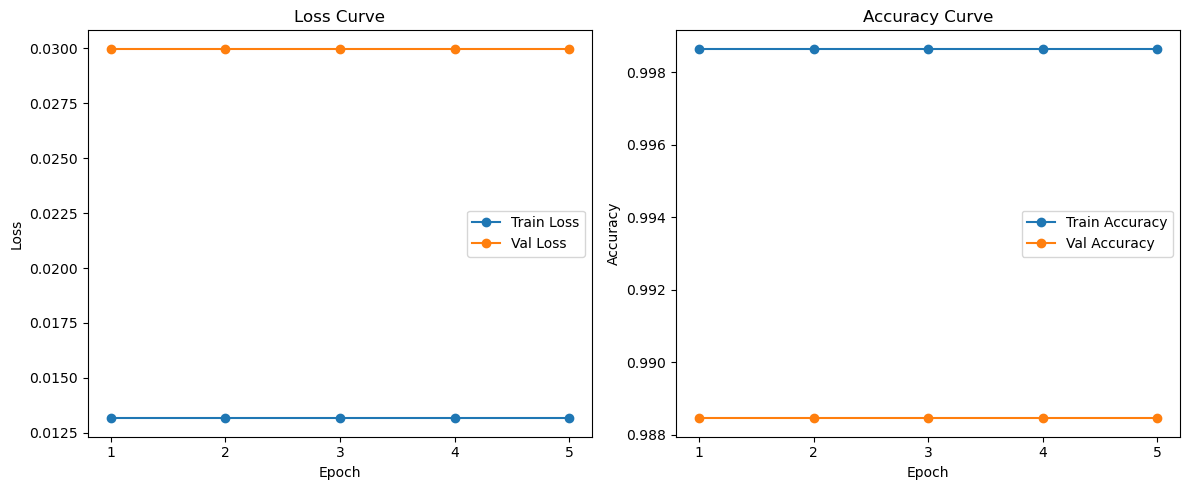

In [ ]:
epochs = range(1, len(train_losses) + 1)  # [1, 2, 3, 4, 5]

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, marker='o', label='Train Accuracy')
plt.plot(epochs, val_accs, marker='o', label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
from sklearn.metrics import confusion_matrix

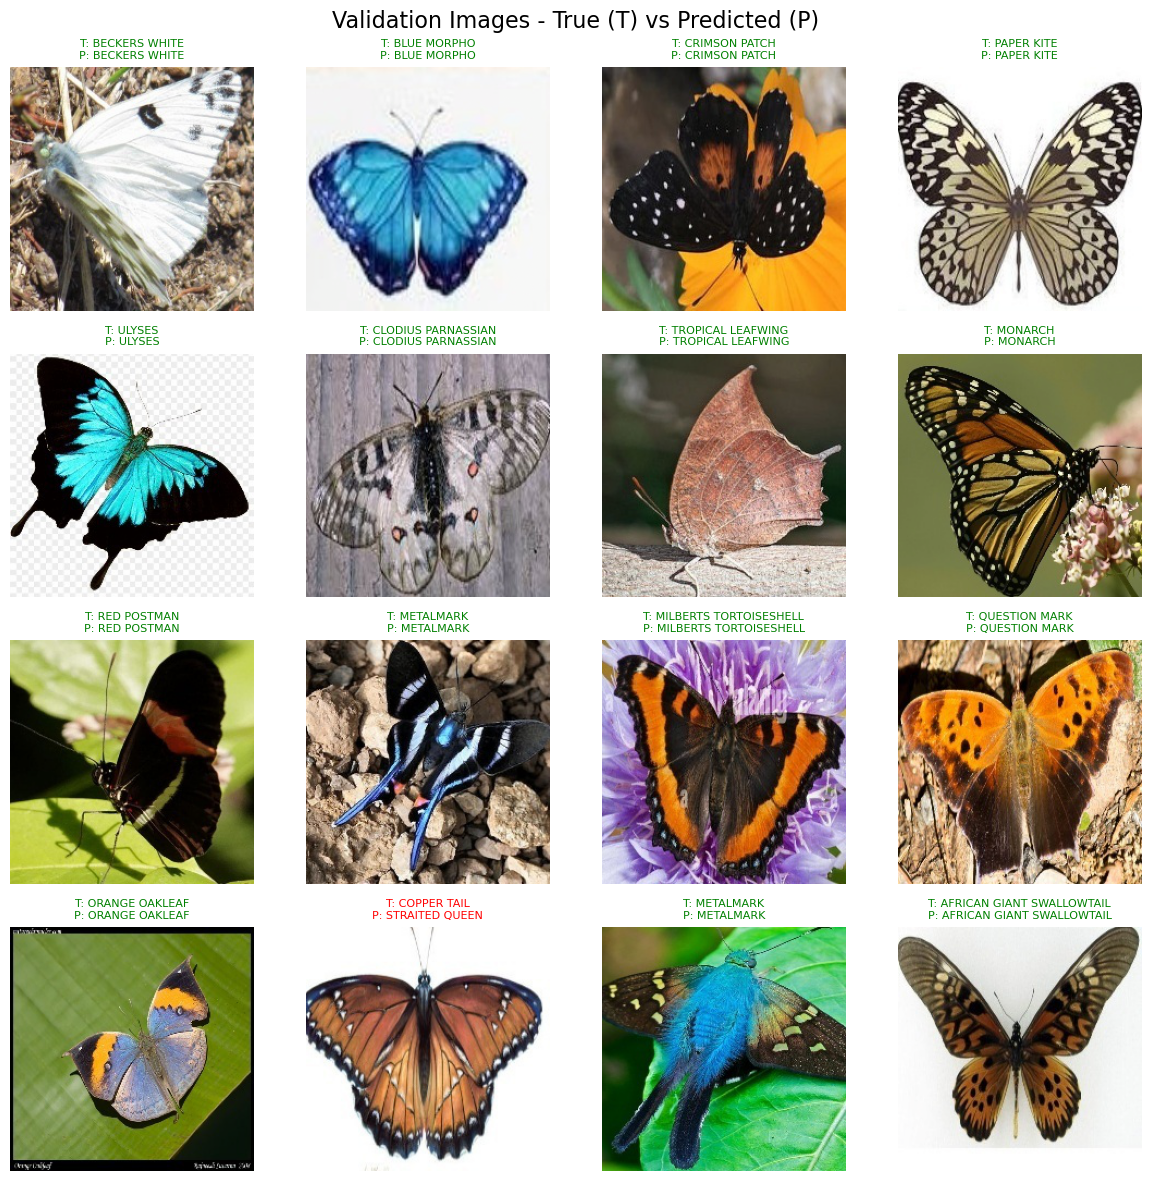

In [30]:
# Show a grid of validation images with true vs predicted labels (green = correct, red = wrong).

# Inverse of ImageNet normalization so images look normal when plotted.
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

# Take one batch from the validation loader.
images, labels = next(iter(val_loader))
images_device = images.to(device)
labels_device = labels.to(device)

resnet.eval()
with torch.no_grad():  # just inference
    outputs = resnet(images_device)
    _, preds = torch.max(outputs, 1)

preds = preds.cpu()
labels = labels.cpu()

num_to_show = min(16, images.size(0))  # show up to 16 images
plt.figure(figsize=(12, 12))

for i in range(num_to_show):
    plt.subplot(4, 4, i + 1)

    img = inv_normalize(images[i])          # undo normalization
    img = img.permute(1, 2, 0).numpy()      # C,H,W -> H,W,C
    img = np.clip(img, 0, 1)                # keep values in [0,1]

    plt.imshow(img)
    plt.axis("off")

    true_label = index_to_label[int(labels[i])]
    pred_label = index_to_label[int(preds[i])]
    color = "green" if true_label == pred_label else "red"

    plt.title(f"T: {true_label}\nP: {pred_label}", color=color, fontsize=8)

plt.suptitle("Validation Images - True (T) vs Predicted (P)", fontsize=16)
plt.tight_layout()
plt.show()